#Zasoby

* Use BigQuery ML to predict penguin weigh

* https://cloud.google.com/bigquery/docs/e2e-journey

* https://cloud.google.com/bigquery/docs/linear-regression-tutorial

* [tabela BQ](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=penguins&page=table&_ga=2.94759004.1744870421.1692803387-633182317.1692803387&project=empik-mobile-app&ws=!1m5!1m4!4m3!1sbigquery-public-data!2sml_datasets!3spenguins&authuser=2)

* https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-glm

#Cele

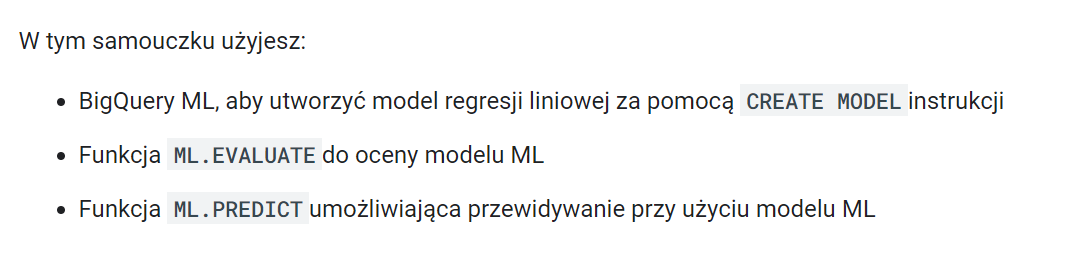

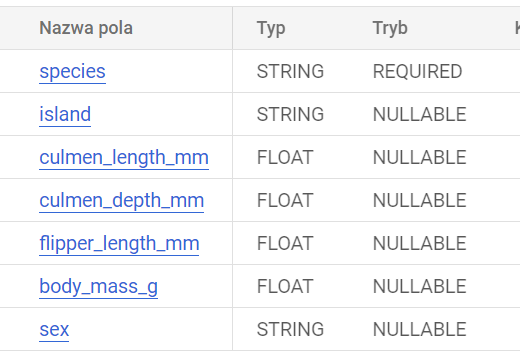

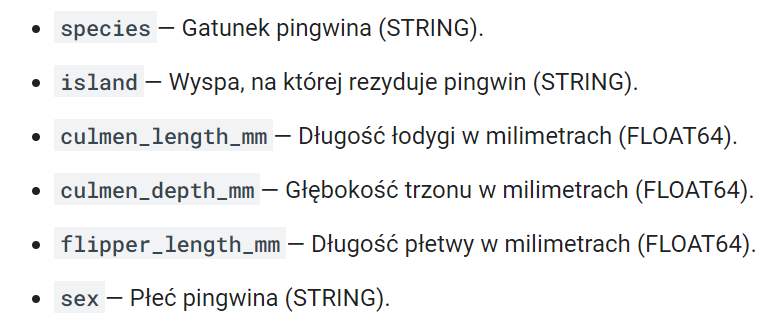

#Stwórz swój model (Krok 1)

## CREATE OR REPLACE MODEL

In [ ]:
%%bigquery

CREATE OR REPLACE MODEL `prj-ecom-p-ad-server-1077.pmackowka_us.model_0061`
OPTIONS
  (model_type='linear_reg',
  input_label_cols=['body_mass_g']) AS
SELECT
  *
FROM
  `bigquery-public-data.ml_datasets.penguins`
WHERE
  body_mass_g IS NOT NULL

In [ ]:
# Tworzy i trenuje nowy model w określonym zestawie danych
# CREATE MODEL | CREATE MODEL IF NOT EXISTS | CREATE OR REPLACE MODEL
CREATE OR REPLACE MODEL `prj-ecom-p-ad-server-1077.pmackowka_us.model_0063`
OPTIONS

  # Typ modelu
  # 'LINEAR_REG' | 'LOGISTIC_REG' (binarna i wieloklasowa)
  (model_type='LINEAR_REG',

  INPUT_LABEL_COLS=['body_mass_g'],

  # Strategia uczenia modeli regresji liniowej
  # 'AUTO_STRATEGY' | 'BATCH_GRADIENT_DESCENT' | 'NORMAL_EQUATION'
  optimize_strategy = 'BATCH_GRADIENT_DESCENT',

  # Regularyzacja, Wartość domyślna to 0.
  L1_REG = 1,
  # Regularyzacja, Wartość domyślna to 0.
  L2_REG = 1,

  # Maksymalna liczba iteracji lub kroków szkoleniowych, Wartość domyślna to 20.
  MAX_ITERATIONS = 50,

  # Strategia określania szybkości uczenia się podczas treningu. Wartość domyślna to 'LINE_SEARCH'.
  # 'LINE_SEARCH' | 'CONSTANT'
  LEARN_RATE_STRATEGY = 'LINE_SEARCH'



  ) AS
SELECT
  *
FROM
  `bigquery-public-data.ml_datasets.penguins`
WHERE
  body_mass_g IS NOT NULL

#Uzyskaj statystyki dotyczące treningu (Krok 2)
* Aby zobaczyć wyniki uczenia modelu możesz skorzystać z `ML.TRAINING_INFO` funkcji lub obejrzeć statystyki w konsoli Google Cloud. W tym samouczku użyjesz konsoli Google Cloud.
* Strata to kara za złe przewidywanie — liczba wskazująca, jak złe były przewidywania modelu w pojedynczym przykładzie. Jeśli przewidywania modelu są doskonałe, strata wynosi zero; w przeciwnym razie strata jest większa. Celem uczenia modelu jest znalezienie zestawu wag i odchyleń, które mają średnio niską stratę we wszystkich przykładach.

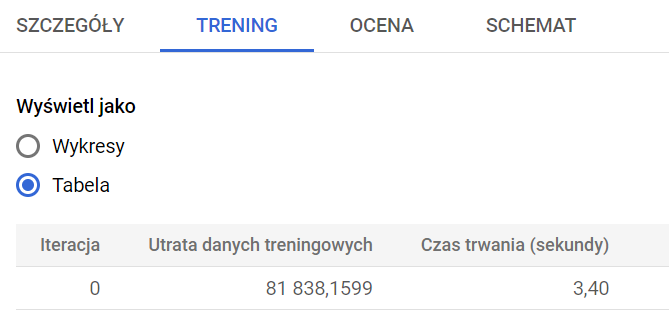

#Oceń swój model (Krok 3)

##ML.EVALUATE

In [ ]:
%%bigquery

SELECT
  *
FROM
  ML.EVALUATE(MODEL `prj-ecom-p-ad-server-1077.pmackowka_us.model_0061`,
    (
    SELECT
      *
    FROM
      `bigquery-public-data.ml_datasets.penguins`
    WHERE
      body_mass_g IS NOT NULL))

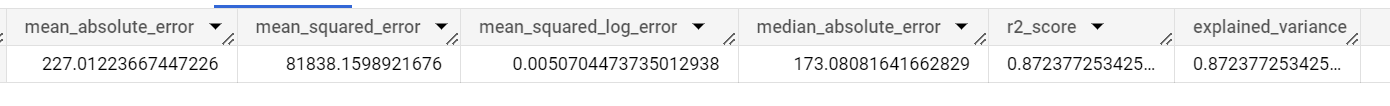

* Można także dzwonić `ML.EVALUATE` bez podawania danych wejściowych

In [ ]:
%%bigquery

SELECT
  *
FROM
  ML.EVALUATE(MODEL `prj-ecom-p-ad-server-1077.pmackowka_us.model_006`)

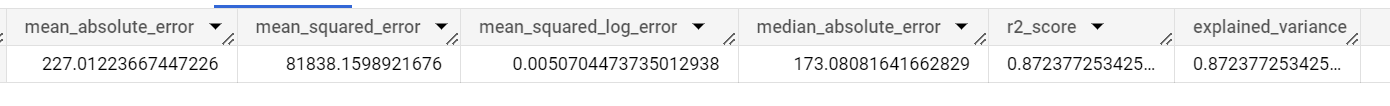

* Możesz także użyć konsoli Google Cloud, aby wyświetlić wskaźniki oceny obliczone podczas szkolenia. Wyniki powinny wyglądać następująco:

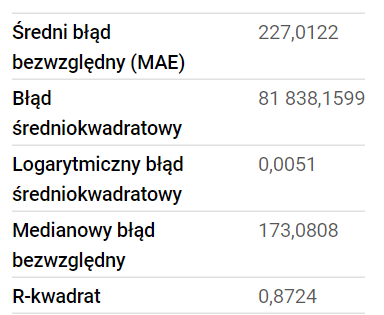

*  Wynik R2 jest miarą statystyczną, która określa, czy przewidywania regresji liniowej są zbliżone do rzeczywistych danych . Wartość 0 wskazuje, że model nie wyjaśnia żadnej zmienności danych odpowiedzi wokół średniej. 1 wskazuje, że model wyjaśnia całą zmienność danych odpowiedzi wokół średniej.

#Użyj swojego modelu do przewidywania wyników (Krok 4)

##ML.PREDICT

* kolumna `predicted_body_mass_g` jest generowana przez `ML.PREDICT` funkcję

In [ ]:
%%bigquery

SELECT
  *
FROM
  ML.PREDICT(MODEL `prj-ecom-p-ad-server-1077.pmackowka_us.model_0061`,
    (
    SELECT
      *
    FROM
      `bigquery-public-data.ml_datasets.penguins`
    WHERE
      body_mass_g IS NOT NULL
      AND island = "Biscoe"))

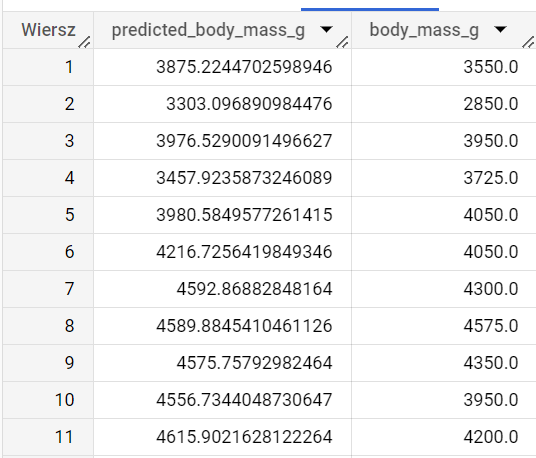

#Wyjaśnij wyniki przewidywań za pomocą możliwych do wyjaśnienia metod AI (Krok 5)

##ML.EXPLAIN_PREDICT

* Aby zrozumieć, dlaczego Twój model generuje takie wyniki przewidywań, możesz użyć tej `ML.EXPLAIN_PREDICT` funkcji.
* ML.EXPLAIN_PREDICT zwraca wyniki prognozy z dodatkowymi kolumnami wyjaśniającymi te wyniki

* https://cloud.google.com/bigquery/docs/xai-overview#explainable_ai_offerings_in_bigquery_ml

In [ ]:
%%bigquery

SELECT
* except(species, island, culmen_length_mm, culmen_depth_mm, flipper_length_mm, sex)
FROM
ML.EXPLAIN_PREDICT(MODEL `prj-ecom-p-ad-server-1077.pmackowka_us.model_0061`,
  (
  SELECT
    *
  FROM
    `bigquery-public-data.ml_datasets.penguins`
  WHERE
    body_mass_g IS NOT NULL
    AND island = "Biscoe"),
  STRUCT(3 as top_k_features)
  )

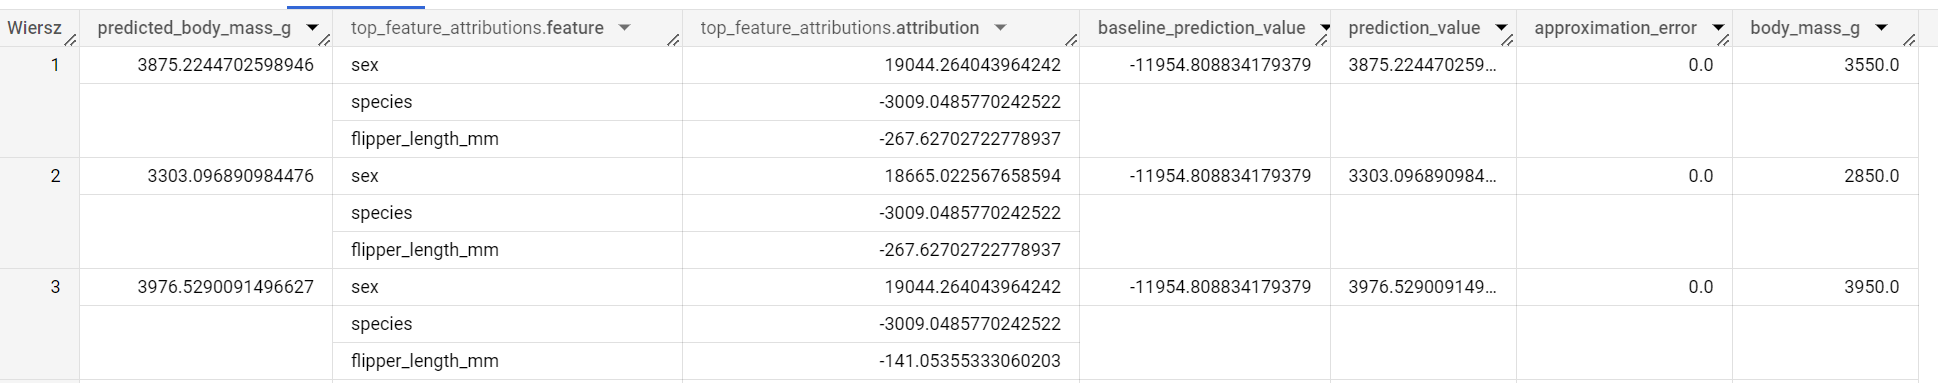

#Globalnie wyjaśnij swój model (Krok 6)

##ML.GLOBAL_EXPLAIN

* Aby móc z niej skorzystać `ML.GLOBAL_EXPLAIN` należy przeszkolić model z opcją `ENABLE_GLOBAL_EXPLAIN=TRUE`


In [ ]:
%%bigquery

CREATE OR REPLACE MODEL `prj-ecom-p-ad-server-1077.pmackowka_us.model_0062`
OPTIONS
  (model_type='linear_reg',
  input_label_cols=['body_mass_g'],
  enable_global_explain=TRUE) AS
SELECT
  *
FROM
  `bigquery-public-data.ml_datasets.penguins`
WHERE
  body_mass_g IS NOT NULL

* Explainable AI pozwala objaśnić model i generowane przez niego prognozy. Poniżej znajdują się cechy o najwyższych wynikach ważności dla całego Twojego modelu. Aby uzyskać możliwe do wyjaśnienia prognozy dla poszczególnych przykładów, uruchom ML.EXPLAIN_PREDICT lub ML.EXPLAIN_FORECAST.

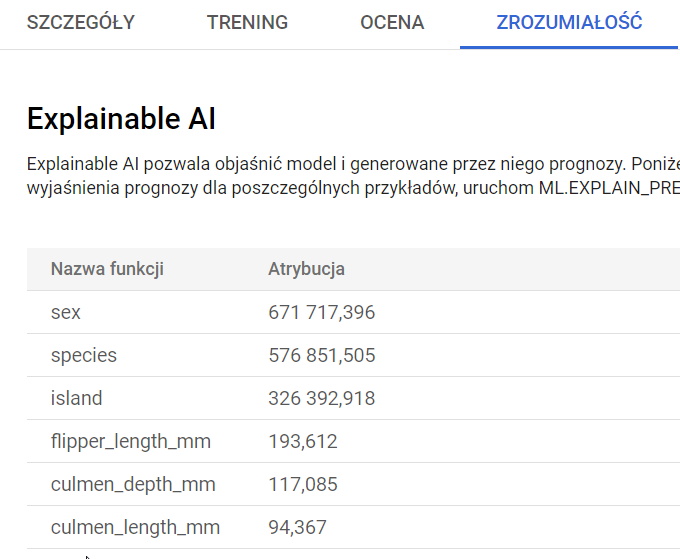

In [ ]:
%%bigquery

SELECT
  *
FROM
  ML.GLOBAL_EXPLAIN(MODEL `prj-ecom-p-ad-server-1077.pmackowka_us.model_0062`)

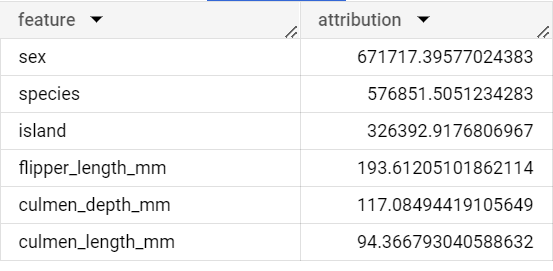